# Barotopic Streamfunction (BSF)

# LENS2 Product
Get an overview of the structure of the BSF
- Inspect data
- Plot global BSF at time = 0
- Apply mask and plot BSF at time = 0 in region
- Plot miminimum of annualy averaged BSF in selected region

# Computation from meridional velocity
Compute stream function manually

# Initialisation

In [14]:
import xarray as xr
import pop_tools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy

# LENS 2 BSF product

In [3]:
filename = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/bsf/bsf_1001.001.nc'

### Inspect data

In [4]:
ds_bsf = xr.open_dataset(filename)
ds_bsf

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2,
                             z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                             z_w_bot: 60, lat_aux_grid: 395, moc_z: 61,
                             nlat: 384, nlon: 320, time: 3012, d2: 2)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 ...
    ULAT                    (nlat, nlon) float64 ...
    TLONG                   (nlat, nlon) float64 ...
    TLAT                    (nlat, nlon) float64 ...
  * time                    (time) object 1850-02-01 00:00:00 ... 2101-01-01 ...
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, nlat,
                                nlon, d2
Data variables: (12/55)
    moc_components          (moc_comp) |S384 ...
    transport_components    (transport_comp) |S384 ...
    transport_regions       (transport_reg) |S384 ...
    dz                      (z_t) float32 ...
    dzw                     (z_w) float32 ...
    KMT                     (nlat, nlon) float64 ...
    ...                      ...
    salinity_factor         float64 ...
    sflux_factor            float64 ...
    nsurface_t              float64 ...
    nsurface_u              float64 ...
    time_bound              (time, d2) object ...
    BSF                     (time, nlat, nlon) float32 ...
Attributes: (12/13)
    title:                     b.e21.BHISTcmip6.f09_g17.LE2-1001.001
    history:                   Mon Dec 26 20:26:02 2022: ncrcat --no_tmp_fl /...
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    time_period_freq:          month_1
    model_doi_url:             https://doi.org/10.5065/D67H1H0V
    contents:                  Diagnostic and Prognostic Variables
    ...                        ...
    revision:                  $Id$
    calendar:                  All years have exactly  365 days.
    start_time:                This dataset was created on 2020-01-31 at 16:3...
    cell_methods:              cell_methods = time: mean ==> the variable val...
    NCO:                       netCDF Operators version 4.7.4 (http://nco.sf....
    nco_openmp_thread_number:  1

### Plot global BSF at time = 0

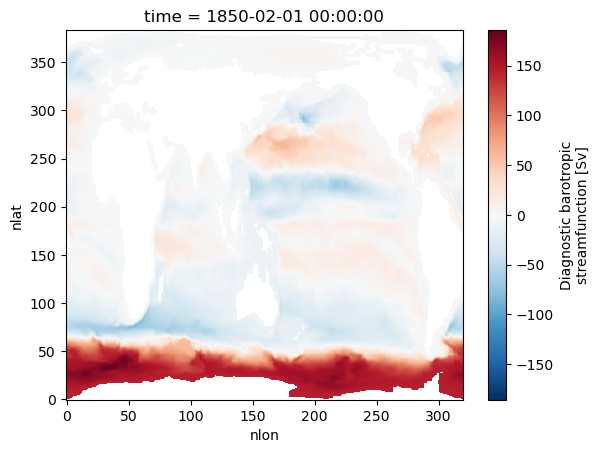

In [5]:
ds_bsf.BSF.isel(time=0).plot()

### Apply mask and plot BSF in region

In [6]:
# setting up of regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [45.0, 66.0], 'TLONG': [280.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
mask3d = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Subpolar Gyre')
mask3d = mask3d.sum('region')  
ds = ds_bsf.where(mask3d == 1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


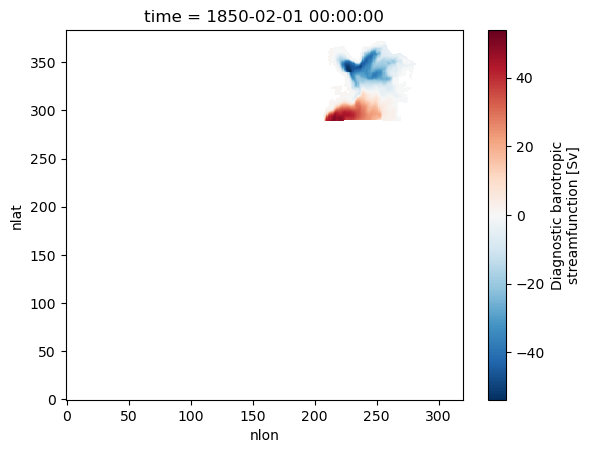

In [10]:
# to center plot roll by 80° longitude
ds.BSF.isel(time=0).roll(nlon=-80).plot()

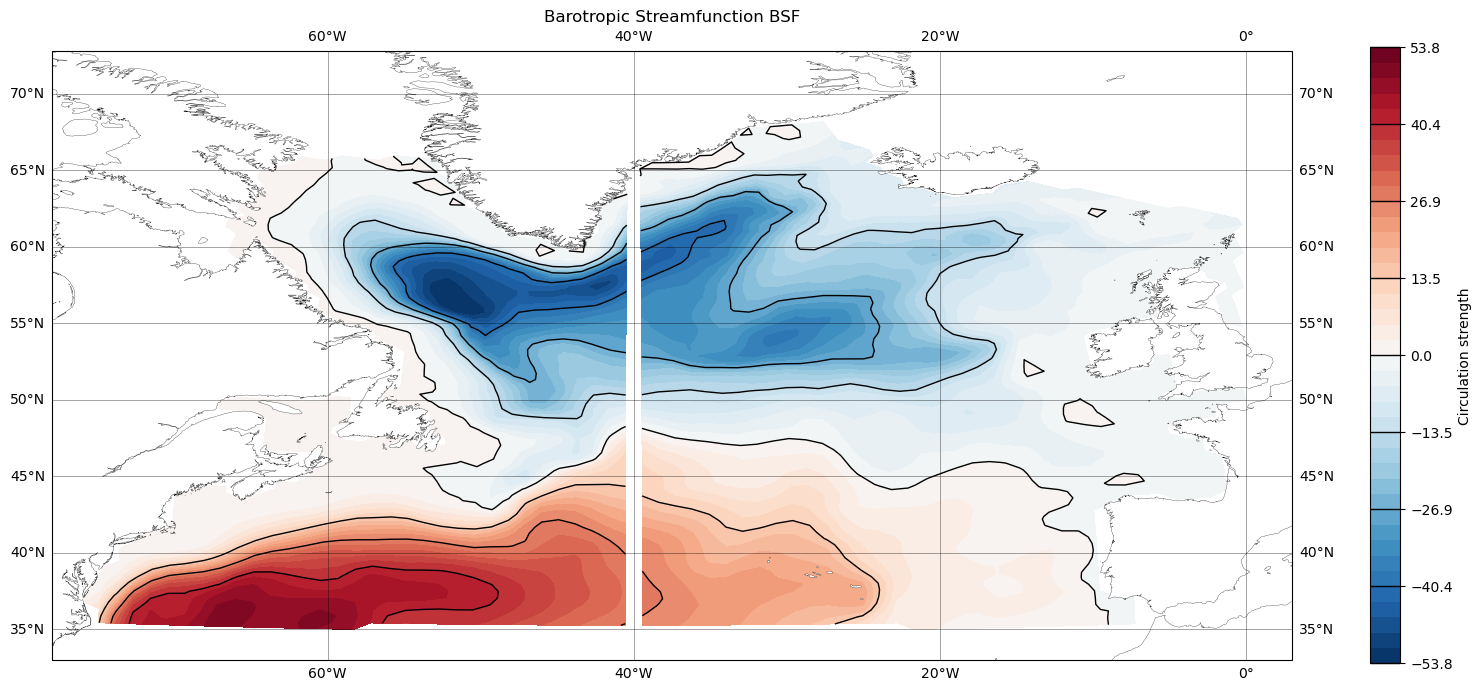

In [21]:
# set kwargs
crs = cartopy.crs.PlateCarree()

vmin = -np.max(np.abs(ds.BSF.isel(time=0)))  # Set vmin to the negative maximum value
vmax = np.max(np.abs(ds.BSF.isel(time=0)))   # Set vmax to the positive maximum value

levels = np.linspace(vmin, vmax, 41)
#cmap = cmo.balance
cmap = 'RdBu_r'
extent = [-78, 3, 33, 68]
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',linewidth=0.2, edgecolor='black', facecolor='white')
title = 'Barotropic Streamfunction BSF'
save_name = 'BSF.png'
         
fig = plt.figure(figsize=(20,8))
ax = plt.axes(projection=crs)
land = ax.add_feature(nature_coast)
ax.gridlines(crs=crs, linewidth=0.5, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent(extent)
ax.set_title(title[j], fontsize=16)
# plot map
cf = ax.contourf(ds.TLONG, ds.TLAT, ds.BSF.isel(time=0), levels=levels, cmap = cmap, norm = norm)
# plot contours
cf2 = ax.contour(ds.TLONG, ds.TLAT, ds.BSF.isel(time=0), levels=levels[::5], colors=['k',],linewidths=1, linestyles='solid')
# plot colorbaar
cbar = fig.colorbar(cf, ax=ax)
cbar.ax.set_ylabel('Circulation strength')
# Add the contour line levels to the colorbar
cbar.add_lines(cf2)
plt.title(title)
plt.show()
#plt.savefig(path+save_name[j], bbox_inches='tight')

### Plot miminimum of annualy averaged BSF in selected region

In [7]:
# annualy average BSF
ds_annual = ds.groupby('time.year').mean('time')
# find minimum of BSF in region per time step
ds_min = ds_annual.BSF.min(('nlon','nlat'))
# extract numpy array 
min_timeseries = ds_min.values
# compute relating time series
time = np.arange(1850,1850+(len(min_timeseries)))

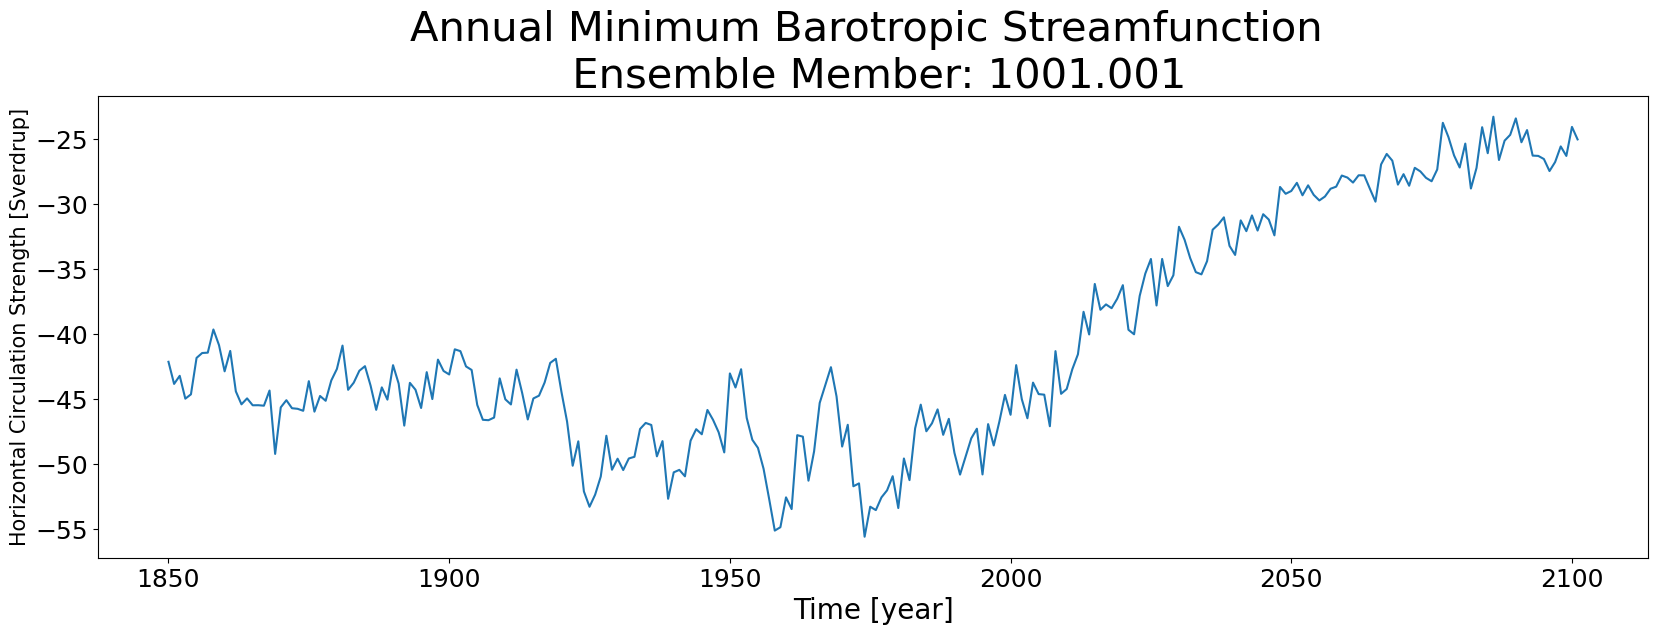

In [8]:
plt.figure(figsize=(20, 6))
plt.plot(time, min_timeseries)
plt.title('Annual Minimum Barotropic Streamfunction \n Ensemble Member: 1001.001', fontsize=30)
plt.xlabel('Time [year]', fontsize=20)
plt.ylabel('Horizontal Circulation Strength [Sverdrup]', fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Computation from meridional velocity

In [23]:
# file name meridional velocity
vvel_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel/vvel_1001.001.nc'
# load data set
ds_vvel = xr.open_dataset(vvel_file)
# apply mask for time = 0
ds_na = ds_vvel.isel(time=0).where(mask3d, 0)

In [27]:
# rotate grrid by -80 degree longitude
ds_nao = ds_na.roll(nlon=-80)

lon_nao = ds_vvel['ULONG'].roll(nlon=-80).data
lat_nao = ds_vvel['ULAT'].roll(nlon=-80).data

lon_nao = np.nan_to_num(lon_nao)
lat_nao = np.nan_to_num(lat_nao)

In [28]:
VVEL_mps = ds_nao.VVEL *1e-2  # Convert cm/s to m/s
dz_m = ds_nao.dz *1e-2  # Convert cm to m
dx_m = ds_nao.DXU *1e-2  # Convert cm to m
V_bt_nao = (VVEL_mps * dz_m * dx_m).sum('z_t')
psi_nao = V_bt_nao.cumsum('nlon') * 1e-6  # Convert m^3/s to Sv

psi_nao_masked = psi_nao.where(mask3d.roll(nlon=-80), 0)

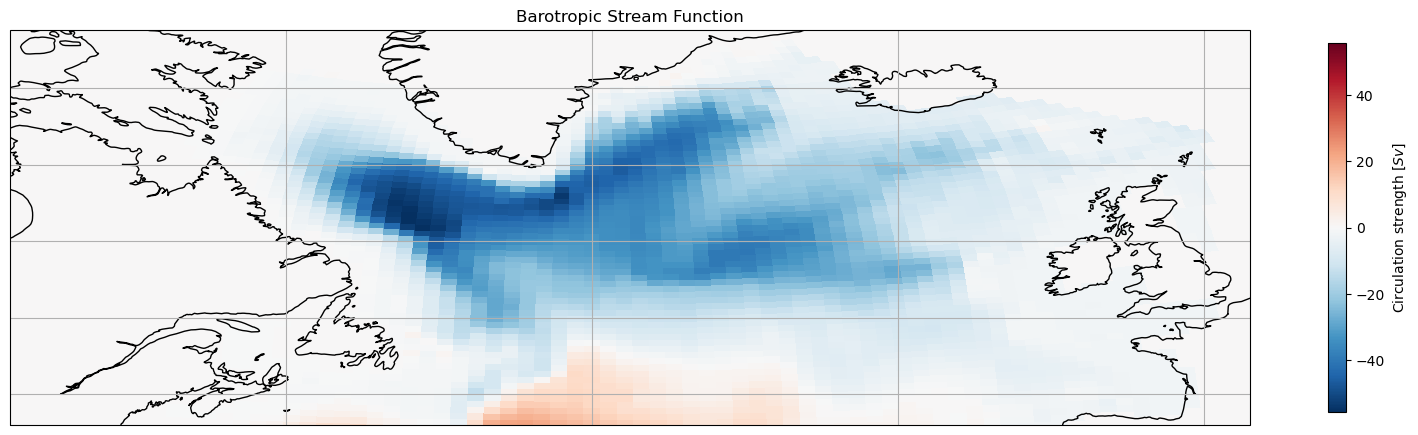

In [30]:
extent = [-78, 3, 43, 63]
vmin = -np.max(np.abs(psi_nao.data))  # Set vmin to the negative maximum value
vmax = np.max(np.abs(psi_nao.data))   # Set vmax to the positive maximum value

fig, ax = plt.subplots(figsize=(20, 8), subplot_kw={'projection': cartopy.crs.PlateCarree()})

ax.set_extent(extent)

pcm = ax.pcolormesh(lon_nao, lat_nao, psi_nao_masked, cmap='RdBu_r', vmin=vmin, vmax=vmax, transform=cartopy.crs.PlateCarree())

ax.coastlines()
ax.gridlines()
cbar = plt.colorbar(pcm, ax=ax, shrink=0.6, label = 'Circulation strength $[Sv]$')  # Colorbar for pcolormesh
plt.title('Barotropic Stream Function', )
plt.show()
#plt.savefig('results/correct_bsf.png', bbox_inches='tight')